In [1]:
import os
from os.path import join
import pandas as pd
import numpy as np
import sklearn as sk
from matplotlib import pyplot as plt

%matplotlib inline
%precision 3

'%.3f'

In [2]:
class G:
    base_dir = os.path.abspath(join(".."))
    data_dir = os.path.abspath(join("..", "data"))

In [3]:
train_df = pd.read_csv(join(G.data_dir, "train_data.csv"), header=0, sep=",")

features = {"predictors": ['x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7'],
            "target": "is_developer"}

xx_data = train_df[features["predictors"]].as_matrix()
yy_data = train_df[features["target"]].as_matrix()
print("positive percentage: {}".format(sum(yy_data) / len(yy_data)))

positive percentage: 0.134


In [10]:
from numpy.random import choice

n_obs = xx_data.shape[0]
sample_idx = choice([True, False], size=n_obs, replace=True, p=[0.8, 0.2])

xx_train, xx_test = xx_data[sample_idx], xx_data[~sample_idx]
yy_train, yy_test = yy_data[sample_idx], yy_data[~sample_idx]

In [13]:
from sklearn.ensemble import AdaBoostClassifier

boost = AdaBoostClassifier()
boost.fit(xx_train, yy_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [68]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import StratifiedKFold

LogisticModel = LogisticRegression(penalty='l1', C=0.1, max_iter=1000)
Boosting = AdaBoostClassifier()
RF = RandomForestClassifier()
SVM = SVC( probability=True)

classifiers = {"Logistic Regression (L1: Lasso)": LogisticModel, 
               "SVM (Kernel=RDF)": SVM,
               "Boosting Tree": Boosting, 
               "Random Forest": RF}

In [69]:
models = classifiers
x = xx_data 
y = yy_data 
k=5 
random_state = None
eval_func = classifier_evaluator

In [70]:
cv = StratifiedKFold( y, n_folds=k, shuffle=False, random_state=random_state)
tot_models = len( models.keys() )

In [71]:
models

{'Boosting Tree': AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
           learning_rate=1.0, n_estimators=50, random_state=None),
 'Logistic Regression (L1: Lasso)': LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=1000, multi_class='ovr', n_jobs=1,
           penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
 'Random Forest': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False),
 'SVM (Kernel=RDF)': SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
   max_iter=-1, pr

In [114]:
from tqdm import tqdm
from pandas import DataFrame

tot_models = len( models.keys() )
tot_iter = tot_models * k 
    
pbar = tqdm(total=tot_iter)

train_reports, test_reports = [], []
for jj, model_name in enumerate(models):
    model = models[model_name]
    # cross-validation evaluation containers
    train_scores = []
    test_scores = []
    # print( "--- model: {}'s cross-validation test ----".format( model_name ) )
    for ii, (train_idx, test_idx) in enumerate(cv):
        # retrieve data for relevant usage
        x_train, y_train = x[train_idx], y[train_idx]
        x_test, y_test = x[test_idx], y[test_idx]
        # training model 
        model.fit( x_train, y_train )
        # evaluation model
        train_score = eval_func( model, x_train, y_train )
        train_score["model_name"] = model_name
        test_score = eval_func( model, x_test, y_test )
        test_score["model_name"] = model_name
        
        train_reports.append( train_score )
        test_reports.append( test_score )
        
        pbar.update()
        
pbar.close()

# convert list of performance records into dataframe
train_reports = DataFrame(train_reports)
test_reports = DataFrame(train_reports)

metrics_names = [feat for feat in train_reports.columns.tolist() if feat != "model_name"]

train_reports.sort_values(by=["model_name"])
train_reports = train_reports[["model_name"] + metrics_names]
test_reports.sort_values(by=["model_name"])
test_reports = test_reports[["model_name"] + metrics_names]

,model_name,accuracy,f1_score,precision,roc_auc,sensitivity,specificity
0,Random Forest,0.993742,0.976077,1,0.999980,0.953271,1
1,Random Forest,0.998750,0.995305,1,0.999993,0.990654,1
2,Random Forest,0.992500,0.971154,1,0.999912,0.943925,1
3,Random Forest,0.993750,0.976077,1,0.999724,0.953271,1
4,Random Forest,0.992509,0.971429,1,1.000000,0.944444,1
5,SVM (Kernel=RDF),0.866083,0.000000,1,0.935714,0.000000,1
6,SVM (Kernel=RDF),0.866250,0.000000,1,0.937155,0.000000,1
7,SVM (Kernel=RDF),0.870000,0.054545,1,0.942941,0.028037,1
8,SVM (Kernel=RDF),0.867500,0.018519,1,0.938032,0.009346,1
9,SVM (Kernel=RDF),0.867665,0.036364,1,0.934838,0.018519,1


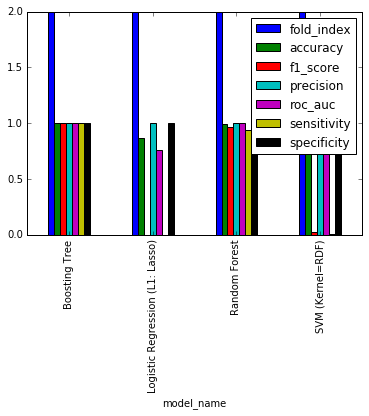

In [103]:
train_reports.groupby("model_name").mean().plot(kind="bar")

In [101]:
train_reports.groupby("model_name").std()

,fold_index,accuracy,f1_score,precision,roc_auc,sensitivity,specificity
model_name,,,,,,,
Boosting Tree,1.581139,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Logistic Regression (L1: Lasso),1.581139,0.000471,0.000000,0.000000,0.036553,0.000000,0.000000
Random Forest,1.581139,0.002403,0.009334,0.000646,0.000127,0.017301,0.000646
SVM (Kernel=RDF),1.581139,0.001569,0.023694,0.000000,0.003157,0.012159,0.000000
